In [1]:
using Plots

In [2]:
### Object declaration
mutable struct Particle
    # Position
    x::Float64
    y::Float64
    # Velocity
    v_x::Float64
    v_y::Float64
    # Other properties: mass, charge
    m::Float64
    q::Float64
    
    # Constructors
    Particle(x, y, v_x, v_y, m, q) = new(x, y, v_x, v_y, m, q)
    Particle(x, y, v_x, v_y) = new(x, y, v_x, v_y, 1, 0)
    
end

function phase_trajectories(p::Particle)
    return (p.x, p.y, p.v_x, p.v_y)
end
#particles = [Particle(i, 2*i, i, i, i, i) for i in 1:3]

phase_trajectories (generic function with 1 method)

In [321]:
K = -10
x = 4.
y = 1.5
#p1 = Particle(0.0, 0.0, 0.0, 1.0)
#p2 = Particle(1, 0.8, 0.5, 0.5)
#particles = [p1, p2]

t_span = (0.0,3.0)
#N_steps = 1000


#function foo(p::Particle)
#    [p.v_x, p.v_y,  K / p.m * (p.x - x) / ((p.x - x)^2 + (p.y - y)^2)^3,K / p.m * (p.y - y) / ((p.x - x)^2 + (p.y - y)^2)^3]
#end
#function foo(u,p,t) 
#    return  [u[3], 
#            u[4],  
#            K * (u[1] - u[5]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3,
#            K * (u[2] - u[6]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3,
#            u[7],
#            u[8],
#            K * (u[5] - u[1]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3,
#            K * (u[6] - u[2]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3]
#            
#end

#function RK4(u, f::Function, dt)
#    k1 = f()
#end

function Forces(p::Particle, dt)
    x = 0.0
    y = 0.0
    (a1, a2) =  [p.x-x, p.y-y] * K/(sqrt((p.x-x)^2 + (p.y-y)^2)^3)
    (p.v_x, p.v_y) = [p.v_x, p.v_y] + dt * [a1, a2]
    (p.x, p.y) = [p.x, p.y] + [p.v_x, p.v_y] + dt * [a1, a2]/2) * dt^2
end

function trajectory(p::Particle, t_range::Tuple, N)
    dt = (t_range[2]-t_range[1])/N
    trajectory = zeros(N+1, 4)
    trajectory[1,:] = [p.x, p.y, p.v_x, p.v_y]
    
    for i in 2:(N+1)
        Forces(p, dt)
        trajectory[i,:] = [p.x, p.y, p.v_x, p.v_y]
    end
    
    return trajectory
end

#phase_trajectories(p1)

#u[:,1] = [p.x,p.y,p.v_x,p.v_y]
#u_0 = Float64[i for j in particles for i in phase_trajectories(j)]
#prob = ODEProblem(foo, u_0, t_span)

#sol = solve(prob)
#plot(sol)

#foo([1,2,1,33], 0, 0)

LoadError: syntax: extra token ")" after end of expression

In [454]:
### Proportionality constants: 
### Coulomb potential & Lennard-Jones potential
κ = 5.
ε = 10.
###
### Particle cross section radius
σ = 0.1
### Restitution coefficient
ρ = 0.8
### Number of particles
N = 100
### Box dimensions
dims = (-4.,4.)
### Box effect [left, right, bottom, top], 1 = normal restitution, >1 = acceleration, <1 = decceleration
effect = (0.8, 0.8, 1.2, 0.8)


function step(particles, i, dt)
    position = zeros(4)
    p = particles[i]

    collision = collisions(particles, i, dt)
    position[1:2] = collision[1]
    position[3:4] = collision[2]
    
    for (index, p_other) in enumerate(particles)         
        if(index != i)
            (a1, a2) = forces(p, p_other)
            
            ### Trajectory and speed in the next step
            position[1:2] .= position[1:2] + position[3:4]*dt + [a1, a2]/2 * dt^2
            position[3:4] .= position[3:4] + dt * [a1, a2]
            
        end        
        
    end
    
    return position
end


function forces(p1, p2; Coulomb=true, Lennard_Jones=true)
    a1, a2 = 0., 0.
    r = sqrt((p1.x-p2.x)^2 + (p1.y-p2.y)^2)
    if(Coulomb)
        (a1, a2) = [p1.x-p2.x, p1.y-p2.y] * p1.q*p2.q*κ/p1.m /r^3
    end
    if(Lennard_Jones)
        r = sqrt((p1.x-p2.x)^2 + (p1.y-p2.y)^2)
        (a1, a2) = [a1, a2] + 
                   [ε*(p1.x - p2.x)*(-12*σ^12 / r^7 + 6*σ^6 / r^4),
                    ε*(p1.y - p2.y)*(-12*σ^12 / r^7 + 6*σ^6 / r^4)]
    end
    
    return [a1, a2]
end


function trajectories(particles, t_range::Tuple, N)
    dt = (t_range[2] - t_range[1])/N
    trajectories = zeros(N + 1, 4 * length(particles))
    for (index, p) in enumerate(particles)
        trajectories[1, (4*index-3):(4*index)] .= [p.x, p.y, p.v_x, p.v_y]
    end

    for i in 2:(N + 1)

        for (index, p) in enumerate(particles)               
            ### Boundary effects
            box(p, dt, effect) 
            ### Complete trajectories
            trajectories[i,(4*index-3):(4*index)] .= step(particles, index, dt)  
            
        end
        
        ### Save positions
        for (index, p) in enumerate(particles)               
            (p.x, p.y, p.v_x, p.v_y) = trajectories[i, (4*index-3):(4*index)]   
        end

    end
    
    return trajectories
end


function collisions(particles, i, dt)
    p = particles[i]
    for (index, p_other) in enumerate(particles)
        if (index != i)
            if(is_collision(p, p_other,dt))
                (vx, vy) = direction(p, p_other)
                v = vx^2 + vy^2
                ### If v == 0 then division by zero
                if (v <= 0.000001)
                    return [[p.x, p.y], [vx, vy]]
                else
                    ### Set position and velocity (position in the direction
                    ### of the velocity unit vector)
                    direction_v = 1/sqrt(v)*[vx, vy]
                    return [[p.x, p.y]+direction_v*σ*dt, [vx, vy]]
                end
            end
        end
    end
    return [[p.x, p.y],[p.v_x, p.v_y]]
end 


function is_collision(p1, p2, dt)
    (p1.x+p1.v_x*dt-p2.x-p2.v_x*dt)^2 + 
    (p1.y+p1.v_y*dt-p2.y-p2.v_y*dt)^2 < σ^2 ? true : false
end


### Change of particle momentum
function direction(p1, p2)
    μ = p1.m + p2.m
    v_x = (p1.m * p1.v_x + p2.m * p2.v_x) / μ
    v_y = (p1.m * p1.v_y + p2.m * p2.v_y) / μ
    pv = [
        v_x - p2.m * ρ * (p1.v_x - p2.v_x) / μ,
        v_y - p2.m * ρ * (p1.v_y - p2.v_y) / μ
    ]
    return pv
    
end


### Borders
function box(p, dt, effect)
    px, py, pvx, pvy = p.x, p.y, p.v_x, p.v_y
    if (px <= dims[1]) 
        p.v_x = -p.v_x*effect[1]
        p.x = dims[1]
    end
    if (px >= dims[2])
        p.v_x = -p.v_x*effect[2]
        p.x = dims[2]
    end
    if (py <= dims[1])
        p.v_y = -p.v_y*effect[3]
        p.y = dims[1]
    end
    if (py >= dims[2])
        p.v_y = -p.v_y*effect[4]
        p.y = dims[2]
    end
end


### Randomly generate particles by criteria
function create_particles(N, μ, charges)
    particles = []
    for i in 1:N
        distr = random_distribution(μ)
        ### Random position and velocity
        x, y, vx, vy = distr[1][1], distr[1][2], distr[2][1], distr[2][2]
        if (charges)
            p = Particle(x, y, vx, vy, 1, rand((-1:1)))
        else
            p = Particle(x, y, vx, vy)
        end
        push!(particles, p)
    end
    return particles
end


function maxwell_distribution(N, μ)
    f(v) = sqrt(1/π)*exp(-(v - μ)^2)

    velocities = []
    
    for i in 1:N
        
    end
end


function random_distribution(μ)
    position = (dims[2]-dims[1]-4*σ)*rand(Float64, (2,1)) + (dims[1]+2*σ)*[1,1]
    velocity = (2*μ-4*σ)*rand(Float64, (2,1)) + (-μ+2*σ)*[1,1]
    return [position, velocity]
end

random_distribution (generic function with 3 methods)

In [455]:
particles = create_particles(30, 2., false)

30-element Array{Any,1}:
 Particle(-2.7278854745941254, -0.9641123830578469, 0.6454979013804907, -0.31942512720531213, 1.0, 0.0)
 Particle(-1.9897765053162582, -1.9177628394005504, -1.0700484221434023, -1.2474871361898165, 1.0, 0.0)
 Particle(-2.4428183285191407, 3.2182034952365344, 0.41647335943718145, -0.34109595304731943, 1.0, 0.0)
 Particle(-0.35318441858985317, 0.8185720063002764, 1.6213543661206977, -0.7788122812968905, 1.0, 0.0)
 Particle(-1.147286995562827, 2.5623821023205338, -0.4332063849883254, 0.14523558225780508, 1.0, 0.0)
 Particle(-0.9455898362231028, 0.6924990476663391, 0.9971399925976272, -0.7755842257171812, 1.0, 0.0)
 Particle(2.5983603160671196, 1.2857546270751428, 1.7823315962310413, -1.719277066106123, 1.0, 0.0)
 Particle(-2.948705961806732, -2.755555329992541, -1.0561018632329482, -1.7241904338782028, 1.0, 0.0)
 Particle(3.4019225369480113, 2.370133736948648, 0.1988348770869075, 0.3326792837148347, 1.0, 0.0)
 Particle(-3.60999746901589, 3.157285136964865, 0.52176

In [456]:
sol = trajectories(particles, (0,0.7), 700)

701×120 Array{Float64,2}:
 -2.72789   -0.964112   0.645498  …  3.1223    1.05212   -1.69881
 -2.70917   -0.973376   0.645497     3.07303   1.05212   -1.69881
 -2.69045   -0.982639   0.645497     3.02377   1.05212   -1.6988
 -2.67173   -0.991902   0.645496     2.9745    1.05212   -1.6988
 -2.65301   -1.00117    0.645496     2.92524   1.05212   -1.6988
 -2.63429   -1.01043    0.645496  …  2.87597   1.05212   -1.6988
 -2.61557   -1.01969    0.645496     2.82671   1.05212   -1.6988
 -2.59685   -1.02896    0.645496     2.77744   1.05212   -1.6988
 -2.57813   -1.03822    0.645496     2.72818   1.05211   -1.6988
 -2.55941   -1.04748    0.645496     2.67891   1.05211   -1.69879
 -2.54069   -1.05675    0.645495  …  2.62965   1.05207   -1.69875
 -2.52197   -1.06601    0.645495     2.62852  -0.285543  -0.0382954
 -2.50325   -1.07527    0.645495     2.58877   0.785404  -1.36751
  ⋮                               ⋱                      
 -0.89852   -0.0173815  0.522605     3.84036  -0.198924  -0.336

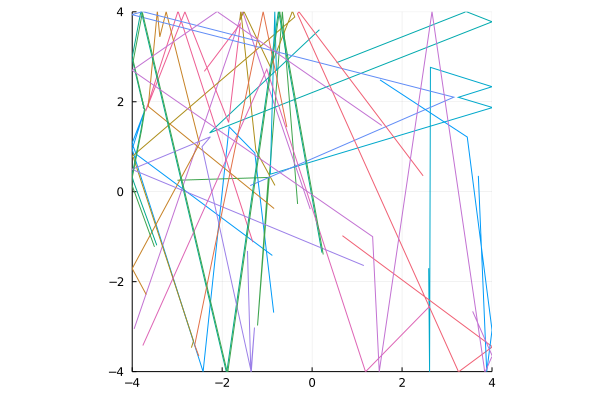

In [452]:
### Plot full trajectories
plot(sol[:,1], sol[:,2], lims=dims, aspect_ratio=:equal, label=false, legend=false)
for (index, p) in enumerate(particles)
    if index == 1
        continue
    end
    plot!(sol[:,(4*index-3)], sol[:,(4*index-2)])
end
current()


In [336]:

@userplot plot_particles
@recipe function f(cp::plot_particles, add_marker = true)
    x, y= cp.args

    aspect_ratio --> 1
    label --> false
    lims --> dims
    markershape --> :circle
    x, y

end



┌ Info: Saved animation to 
│   fn = /Users/tadeasnemec/Programming/Git/Particles_In_Box/particle_sim.gif
└ @ Plots /Users/tadeasnemec/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/Users/tadeasnemec/Programming/Git/Particles_In_Box/particle_sim.gif")
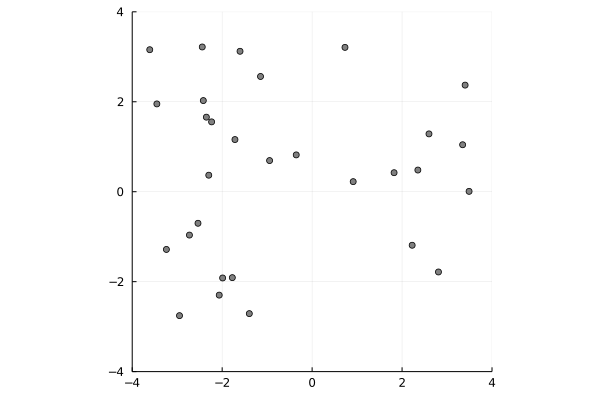

In [457]:
### Colors corresponding to charge:
colors = Dict(-1 => :blue, 0 => :gray, 1 => :red)

anim = @animate for i ∈ 1:length(sol[:,1])
    plot_particles(sol[i:i,1], sol[i:i,2], markercolor = colors[particles[1].q])
    for (index, p) in enumerate(particles)
        if index == 1
            continue
        end
        plot_particles!(sol[i:i,(4*index-3)], sol[i:i,(4*index-2)], markercolor = colors[p.q])
    end
end
gif(anim, "particle_sim.gif", fps = 70)

